<a href="https://colab.research.google.com/github/swet-s/HC_Reg/blob/main/HC_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import os
import math
import copy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torchvision

# import skimage
from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch.nn.functional as F

In [3]:
EPOCHS = 4
USE_GPU = False

#Download Data

In [4]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# download link: https://drive.google.com/file/d/1nx8oTD1mdhB9e19xAZQYsdgOPt-4QUvl/view?usp=sharing
file_id_1 = '1nx8oTD1mdhB9e19xAZQYsdgOPt-4QUvl'  
downloaded_1 = drive.CreateFile({'id': file_id_1}) 

# download link: https://drive.google.com/file/d/1OSrIuKWasvLss0Ewbx5EyTEPKSQ1nM6k/view?usp=sharing
file_id_2 = '1OSrIuKWasvLss0Ewbx5EyTEPKSQ1nM6k'  
downloaded_2 = drive.CreateFile({'id': file_id_2})

# download link: https://drive.google.com/file/d/1dNPGG7FeI3vOC6lFsRhLdt4IrpIj1enH/view?usp=sharing
file_id_3 = '1dNPGG7FeI3vOC6lFsRhLdt4IrpIj1enH' 
downloaded_3 = drive.CreateFile({'id': file_id_3})

# download link: https://drive.google.com/file/d/1lzKa0JqdE3Aquq0jcpQf1VilVIEvznCn/view?usp=share_link
file_id_4 = '1lzKa0JqdE3Aquq0jcpQf1VilVIEvznCn' 
downloaded_4 = drive.CreateFile({'id': file_id_4})

In [6]:
downloaded_1.GetContentFile('train.zip')
downloaded_2.GetContentFile('test.zip')
downloaded_3.GetContentFile('test_set_pixel_size.csv')
downloaded_4.GetContentFile('training_set_pixel_size_and_HC.csv')

!unzip train.zip
!unzip test.zip

Archive:  train.zip
   creating: train/
  inflating: train/002_HC_Mask.png   
  inflating: train/003_HC_Mask.png   
  inflating: train/004_HC_Mask.png   
  inflating: train/005_HC_Mask.png   
  inflating: train/008_HC_Mask.png   
  inflating: train/010_2HC_Mask.png  
  inflating: train/010_HC_Mask.png   
  inflating: train/011_HC_Mask.png   
  inflating: train/013_HC_Mask.png   
  inflating: train/014_3HC_Mask.png  
  inflating: train/015_HC_Mask.png   
  inflating: train/016_HC_Mask.png   
  inflating: train/017_2HC_Mask.png  
  inflating: train/017_HC_Mask.png   
  inflating: train/019_2HC_Mask.png  
  inflating: train/020_HC_Mask.png   
  inflating: train/021_HC_Mask.png   
  inflating: train/023_2HC_Mask.png  
  inflating: train/023_HC_Mask.png   
  inflating: train/025_HC_Mask.png   
  inflating: train/027_HC_Mask.png   
  inflating: train/028_HC_Mask.png   
  inflating: train/029_HC_Mask.png   
  inflating: train/032_HC_Mask.png   
  inflating: train/033_2HC_Mask.png  
  inflatin

In [7]:
!rm -r train.zip
!rm -r test.zip

#Next

In [8]:
df = pd.read_csv("/content/training_set_pixel_size_and_HC.csv")

In [9]:
df.head()

,filename,pixel size(mm),head circumference(mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [10]:
filename = df['filename']
hc = df['head circumference(mm)']
pix_sz = df['pixel size(mm)']

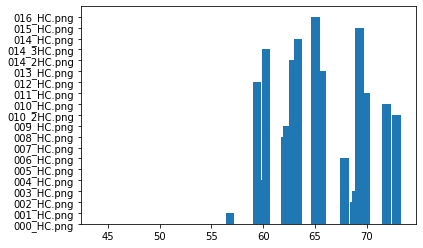

In [11]:
plt.bar(hc[0:20], filename[0:20])
plt.show()

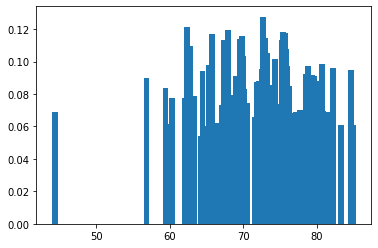

In [12]:
plt.bar(hc[0:100], pix_sz[0:100])
plt.show()

In [13]:
train_indices, test_indices = train_test_split(df.index, test_size=0.25)

In [14]:
train_indices.shape, test_indices.shape

((749,), (250,))

In [15]:
transform_pipe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    # Resize image to 224 x 224 as required by most vision models
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    
    # Convert PIL image to tensor with image values in [0, 1]
    torchvision.transforms.ToTensor(),
    
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [53]:
class HCDataset(torch.utils.data.Dataset):
    
    
    def __init__(self, img_dir, labels_csv_file, transform=None):
        self.img_dir = img_dir
        self.labels_df = pd.read_csv(labels_csv_file)
        self.transform = transform
        
    def __getitem__(self, idx):
        try:
            img_path = os.path.join(
                self.img_dir,
                "{}".format(self.labels_df.iloc[idx, 0])
            )
        except AttributeError:
            img_path = self.images[idx]

        # print("img_path:", img_path)
        img = imread(img_path, as_gray = False)
        
        if self.transform:
            img = self.transform(img)
        
        sample = {
            "image": img,
        }
        try:
            sample["filename"] = self.labels_df.loc[idx, "filename"]
            sample["pixel size(mm)"] = self.labels_df.loc[idx, "pixel size(mm)"]
            sample["head circumference(mm)"] = self.labels_df.loc[idx, "head circumference(mm)"]
        except AttributeError:
            sample["id"] = os.path.basename(self.images[idx]).replace("_HC.png", "")
        
        return sample
    
    def __len__(self):
        try:
            return self.labels_df.shape[0]
        except AttributeError:
            return len(self.images)

In [54]:
train_data = HCDataset(
    img_dir="/content/train/",
    labels_csv_file="/content/training_set_pixel_size_and_HC.csv",
    transform=transform_pipe
)

In [55]:
train_data.labels_df

,filename,pixel size(mm),head circumference(mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81
...,...,...,...
994,801_HC.png,0.296851,329.26
995,802_HC.png,0.212267,330.90
996,803_HC.png,0.202743,331.70
997,804_HC.png,0.281090,316.48


In [56]:
len(train_data)

999

In [57]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64,
    sampler=torch.utils.data.SubsetRandomSampler(
        train_indices
    )
#     shuffle=True,
#     num_workers=8
)

In [58]:
test_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64,
    sampler=torch.utils.data.SubsetRandomSampler(
        test_indices
    )
#     shuffle=True,
#     num_workers=8
)

In [59]:
dataloaders = {
    "train": train_loader,
    "test": test_loader
}

In [60]:
class Flatten(torch.nn.Module):
    """
    Custom flatten module like what is available in Keras.
    """
    
    def forward(self, input):
        return input.view(input.size(0), -1)

In [61]:
model = torchvision.models.resnet50()

In [62]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=1
    ),
    torch.nn.Sigmoid()
)

In [ ]:
# model

In [63]:
out = model(train_data[0]["image"].view(1, 3, 224, 224))
out.shape

torch.Size([1, 1])

In [64]:
train_data[0]["filename"]

'000_HC.png'

In [65]:
train_data[0]["pixel size(mm)"]

0.0691358041432

In [66]:
train_data[0]["head circumference(mm)"]


44.3

In [67]:
# Some utils functions.
# Seems like PyTorch does not auto-infer tensor shapes in a sequential model, so we need to figure the shapes ourself.

def compute_conv2d_output_dimensions(Hin, Win, kernel_size, padding=(0, 0), dilation=(1, 1), stride=(1, 1)):
    Hout = math.floor(((Hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0]) + 1)
    Wout = math.floor(((Win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1]) + 1)
    return Hout, Wout


def compute_maxpooling2d_output_dimensions(Hin, Win, kernel_size, stride=None, padding=(0, 0), dilation=(1, 1)):
    if stride is None:
        stride = kernel_size
    
    Hout = math.floor(((Hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0]) + 1)
    Wout = math.floor(((Win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1]) + 1)
    return Hout, Wout

In [68]:
compute_conv2d_output_dimensions(96, 96, (3, 3))
compute_maxpooling2d_output_dimensions(94, 94, kernel_size=(2, 2))

(47, 47)

In [69]:
epsilon = 0.01

In [72]:
if USE_GPU:
    model = model.cuda() # Should be called before instantiating optimizer according to docs: https://pytorch.org/docs/stable/nn.html

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for i in range(EPOCHS):
    for phase in ["train", "test"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        samples = 0
        loss_sum = 0
        correct_sum = 0
        for j, batch in enumerate(dataloaders[phase]):
            print(phase + " batch: {} / {}".format(j + 1, i + 1))
            X = batch["image"]

            names = batch["filename"]
            labels = batch["head circumference(mm)"]
            labels = torch.nn.functional.normalize(labels, p=1.0, dim = 0)
            pix_sz = batch["pixel size(mm)"]

            # plt.imshow(X[0].permute(1, 2, 0))
            # print(names[0], pix_sz[0], labels[0])

            if USE_GPU:
                X = X.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y = model(X)
                loss = criterion(
                    y, 
                    labels.view(-1, 1).float()
                )

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    
                loss_sum += loss.item() * X.shape[0] # We need to multiple by batch size as loss is the mean loss of the samples in the batch
                samples += X.shape[0]
                # print(y, labels.view(-1, 1).float())
                num_corrects = torch.sum((y.float() - labels.view(-1, 1).float())<=epsilon)
                correct_sum += num_corrects
                
                # Print batch statistics every 50 batches
                if j % 50 == 49 and phase == "train":
                    print("{}:{} - loss: {}, acc: {}".format(
                        i + 1, 
                        j + 1, 
                        float(loss_sum) / float(samples), 
                        float(correct_sum) / float(samples)
                    ))
                
        # Print epoch statistics
        epoch_acc = float(correct_sum) / float(samples)
        epoch_loss = float(loss_sum) / float(samples)
        print("epoch: {} - {} loss: {}, {} acc: {}".format(i + 1, phase, epoch_loss, phase, epoch_acc))
        
        # Deep copy the model
        if phase == "test" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "resnet50.pth")

train batch: 1 / 1
train batch: 2 / 1
train batch: 3 / 1
train batch: 4 / 1
train batch: 5 / 1
train batch: 6 / 1
train batch: 7 / 1
train batch: 8 / 1
train batch: 9 / 1
train batch: 10 / 1
train batch: 11 / 1
train batch: 12 / 1
epoch: 1 - train loss: 0.08725565381457555, train acc: 0.9919893190921228
test batch: 1 / 1
test batch: 2 / 1
test batch: 3 / 1
test batch: 4 / 1
epoch: 1 - test loss: 0.8410679354667664, test acc: 0.064
train batch: 1 / 2
train batch: 2 / 2
train batch: 3 / 2
train batch: 4 / 2
train batch: 5 / 2
train batch: 6 / 2
train batch: 7 / 2
train batch: 8 / 2
train batch: 9 / 2
train batch: 10 / 2
train batch: 11 / 2
train batch: 12 / 2
epoch: 2 - train loss: 0.08192302947130317, train acc: 1.0
test batch: 1 / 2
test batch: 2 / 2
test batch: 3 / 2
test batch: 4 / 2
epoch: 2 - test loss: 0.10644981276988984, test acc: 0.652
train batch: 1 / 3
train batch: 2 / 3
train batch: 3 / 3
train batch: 4 / 3
train batch: 5 / 3
train batch: 6 / 3
train batch: 7 / 3
train batch

In [ ]:
# torch.save(best_model_wts, "resnet50.pth")

In [ ]:
model1 = torchvision.models.resnet50()
model1.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=1
    ),
    torch.nn.Sigmoid()
)
model1.load_state_dict(torch.load("resnet50.pth"))

<All keys matched successfully>

In [ ]:
test_data = HCDataset(
    img_dir="/content/train/",
    labels_csv_file="/content/training_set_pixel_size_and_HC.csv",
    transform=transform_pipe
)

In [ ]:
test_loader1 = torch.utils.data.DataLoader(
    test_data,
    batch_size=64,
#     shuffle=True,
#     num_workers=8
)

In [ ]:
len(test_data)

999

In [ ]:
test_data[0]

In [ ]:
model1.eval()
if USE_GPU:
    model1 = model1.cuda()

ids_all = []
predictions = []

for j, batch in enumerate(test_loader1):
    X = batch["image"]

    ids = batch["filename"]
    if USE_GPU:
        X = X.cuda()
    
    for _id in ids:
        ids_all.append(_id)

    with torch.set_grad_enabled(False):
        y_pred = model1(X)
        predictions.append((y_pred*180).float().cpu().numpy())
        
print("Done making predictions!")

In [ ]:
predictions

In [ ]:
submissions = pd.DataFrame({
    "filename": ids_all,
    "head circumference(mm)": np.concatenate(predictions).reshape(-1,).astype("int")
}).set_index("filename")

In [ ]:
submissions.head()

,head circumference(mm)
filename,
000_HC.png,1
001_HC.png,1
002_HC.png,1
003_HC.png,1
004_HC.png,2


In [ ]:
submissions.to_csv("submissions.csv")